In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import pickle
import sbi.utils as utils
import torch
from sbi.inference import MCMCPosterior
from scipy.special import logsumexp
from seaborn import histplot

import sys  
sys.path.insert(1, '../')
from collective_posterior import CollectivePosterior
from simulators import SLCP, SLCP_wrapper
import sbibm
from seaborn import pairplot
import warnings
warnings.simplefilter('ignore', FutureWarning)


prior = sbibm.get_task('slcp').get_prior_dist()
t = prior.sample((1,))[0]

X = SLCP_wrapper(reps=10, parameters=t)
# g = pairplot(pd.DataFrame(X.numpy()))
# for i in range(len(t)):
#     g.axes[i,i].axvline(t[i],color='red', linewidth=3)
#     g.axes[i,i].set_xlim(prior.base_dist.low[i], prior.base_dist.high[i])

In [16]:
posterior_cp = pickle.load(open('posteriors/posterior_SLCP_10000_20.pkl', 'rb'))
epsilon = -10000 # choice is detailed later
op = CollectivePosterior(prior,X, posterior_cp, 1, epsilon)
print(op.get_log_C())

tensor(151.6529)


Rejection Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/SLCP/../collective_posterior.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
Rejection Sampling: 1385it [00:01, 898.78it/s]                         


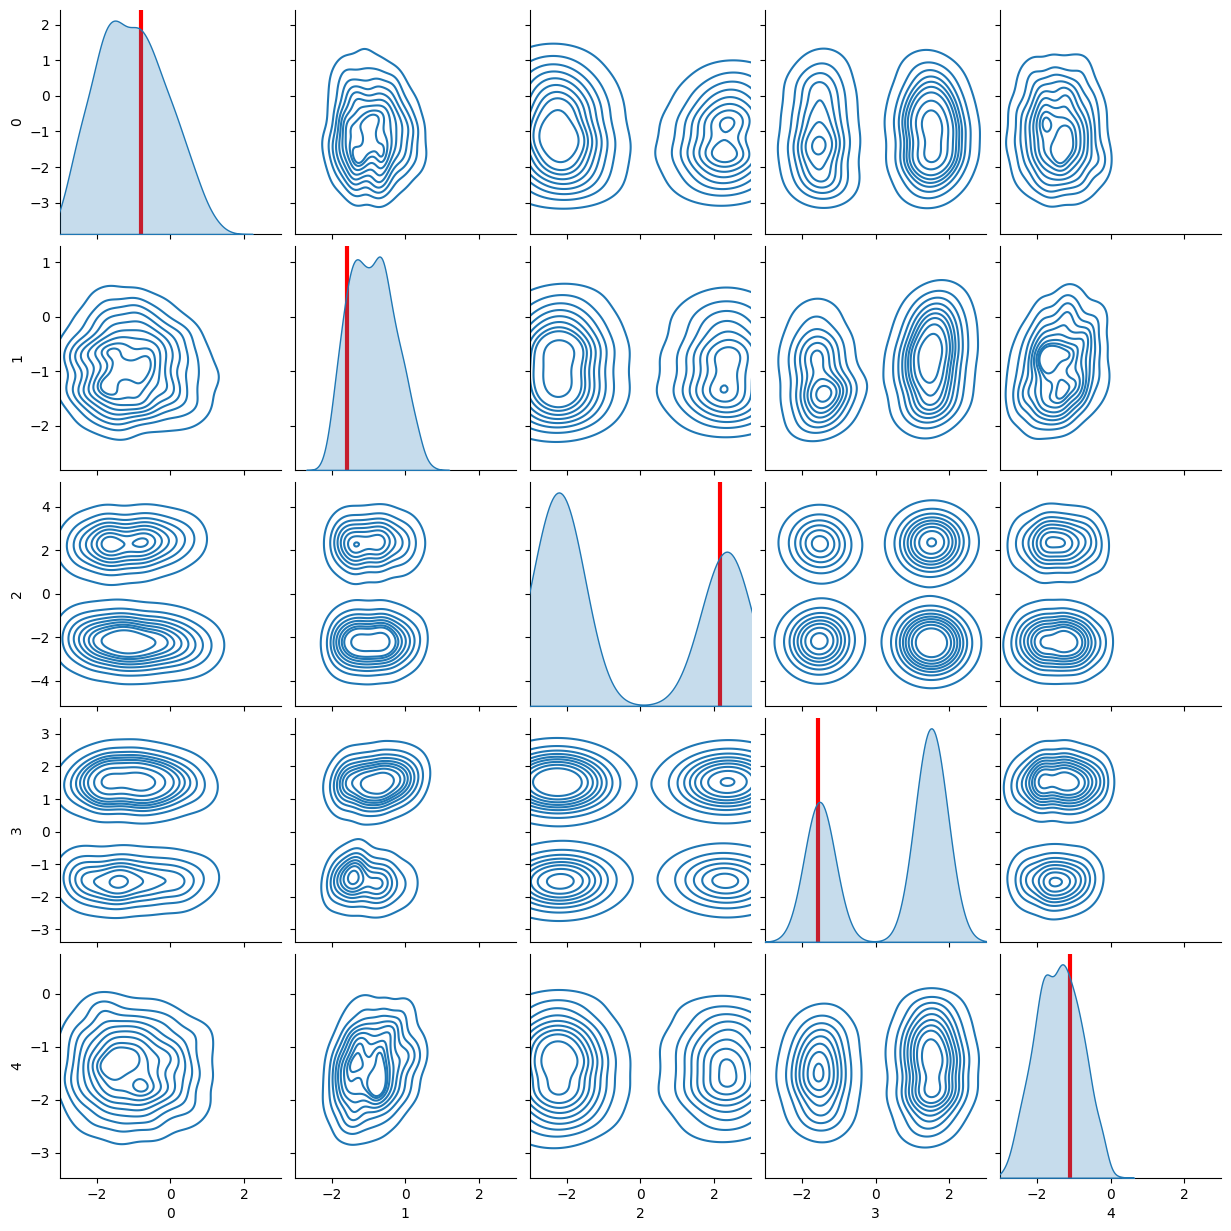

In [17]:
g = pairplot(pd.DataFrame(op.rejection_sample(1000).numpy()), kind='kde')
for i in range(len(t)):
    g.axes[i,i].axvline(t[i],color='red', linewidth=3)
    g.axes[i,i].set_xlim(prior.base_dist.low[i], prior.base_dist.high[i])

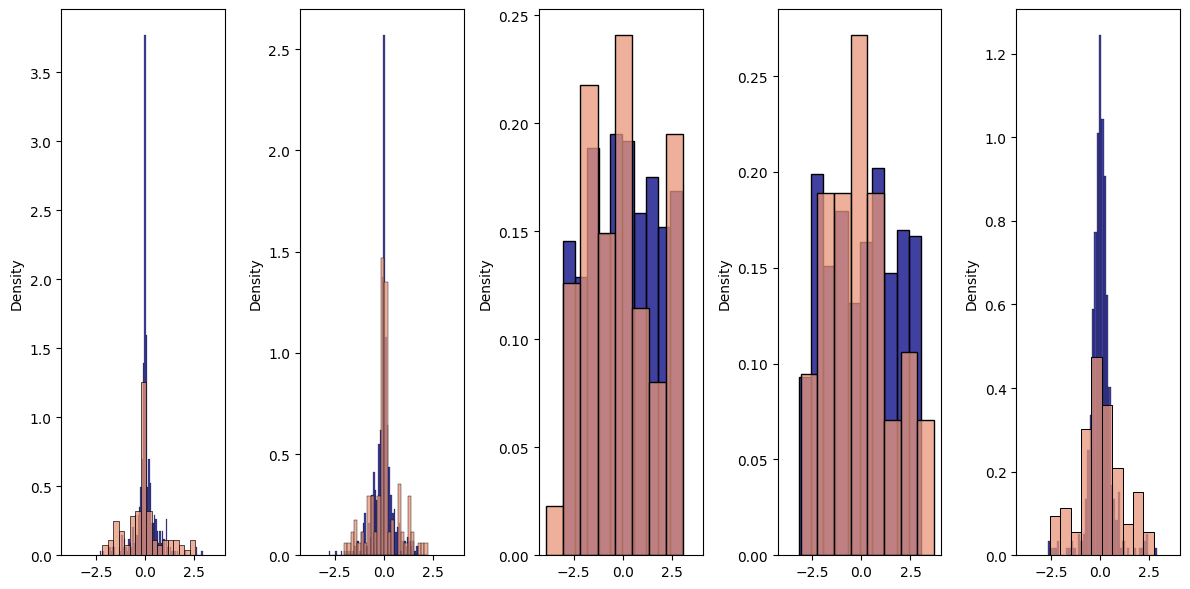

In [18]:
def plot_accuracy(acc_path, ax, color):
    res = pd.read_csv(acc_path, index_col=0, dtype='float')
    res = torch.from_numpy(np.array(res))
    for i in range(len(ax)):
        histplot(res[:,i],ax=ax[i], stat='density', color=color)
    return

n_params=5
fig, ax = plt.subplots(1,n_params, figsize=(12,6), tight_layout=True, sharex=True)


iid_acc = 'tests/accus_SLCP_iid.csv'
plot_accuracy(iid_acc, ax, color='navy')

cp_acc = 'tests/accus_SLCP_100.csv'
plot_accuracy(cp_acc, ax, color='darksalmon')


         0
314.0  0.0
311.0  0.0
393.0  0.0
66.0   0.0
221.0  0.0
...    ...
207.0  1.0
206.0  1.0
205.0  1.0
220.0  1.0
249.0  1.0

[500 rows x 1 columns]


/tmp/ipykernel_1141987/3171389242.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  H,X1 = np.histogram(covs, bins = 100, normed = True)
/tmp/ipykernel_1141987/3171389242.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  H,X1 = np.histogram(covs, bins = 100, normed = True)


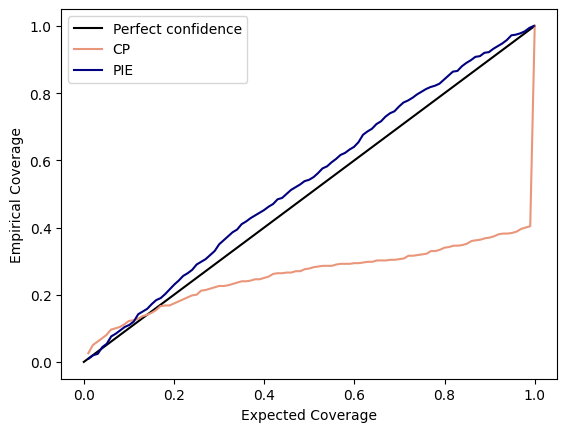

In [16]:
def plot_covs(covs, ax, label, color):
    H,X1 = np.histogram(covs, bins = 100, normed = True)
    dx = X1[1] - X1[0]
    F1 = np.cumsum(H)*dx
    ax.plot(X1[1:], F1, label = label, color=color)

    ax.set_xlabel('Expected Coverage')
    ax.set_ylabel('Empirical Coverage')
    ax.legend()
    return

fig, ax = plt.subplots()
ax.plot(np.linspace(0,1,100),np.linspace(0,1,100), color='k', label='Perfect confidence')
covs = pd.read_csv('tests/covs_SLCP.csv', index_col=0, dtype='float')
plot_covs(covs,ax,label='CP',color='darksalmon')

print(covs.sort_values(by='0'))

covs_iid = pd.read_csv('tests/covs_SLCP_iid.csv', index_col=0, dtype='float') / 2
covs_iid.to_csv('tests/covs_SLCP_iid.csv')
plot_covs(covs_iid,ax,label='PIE',color='navy')

In [ ]:
def coverage_old(posterior, conf_levels, thetas):
    covs = torch.empty(len(thetas),len(conf_levels), len(thetas[0]))
    ratios = torch.empty(len(thetas),len(conf_levels), len(thetas[0]))
    for i in range(len(thetas)):
        cp = CollectivePosterior(prior=prior, amortized_posterior=posterior, log_C=1, Xs=SLCP_wrapper(100, thetas[i]),epsilon=-10000)
        cp.get_log_C()
        num_samps = 200
        samples = cp.sample(num_samps)
        params = torch.tensor(thetas[i,:], dtype=torch.float32)
        sorted_probs, ind = torch.sort(cp.log_prob(samples), descending=True)
        for j in range(len(conf_levels)):
            conf_level = conf_levels[j]   
            samples_trimmed = samples[ind]
            probs = samples_trimmed[:int(conf_level*num_samps)+1]
            # hdi = [torch.quantile(samples, (1-conf_level)/2, 0), torch.quantile(samples,(1+conf_level)/2, 0)]
            hdi = [probs.min(0)[0], probs.max(0)[0]]
            ratio = (hdi[1]-hdi[0])/ (prior.base_dist.high-prior.base_dist.low)
            ratios[i,j] = ratio
            covs[i,j] = ((params > hdi[0])*(params < hdi[1]))
        print(i)
    return covs, np.array(covs.mean(0)), np.array(ratios.mean(0))

thetas = prior.sample((100,))
covs, covs_mean, ratios_mean = coverage_old(posterior_cp, [0.25,0.5,0.8,0.95], thetas)
covs_mean, ratios_mean

/tmp/ipykernel_1046849/4014294943.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  params = torch.tensor(thetas[i,:], dtype=torch.float32)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78


In [18]:
sbi_posterior = pickle.load(open(f'posteriors/posterior_iid_SLCP_10000_20.pkl', 'rb'))

conf_levels = [0.25,0.5,0.8,0.95]
covs = torch.empty(len(thetas),len(conf_levels), len(thetas[0]))
cp = sbi_posterior
ratios = torch.empty(len(thetas),len(conf_levels), len(thetas[0]))
for i in range(len(thetas)):
    X = SLCP_wrapper(10, thetas[i])
    num_samps = 200
    samples = cp.set_default_x(X).sample((num_samps,))
    params = torch.tensor(thetas[i,:], dtype=torch.float32)
    sorted_probs, ind = torch.sort(cp.log_prob(samples), descending=True)
    for j in range(len(conf_levels)):
        conf_level = conf_levels[j]   
        samples_trimmed = samples[ind]
        probs = samples_trimmed[:int(conf_level*num_samps)+1]
        # hdi = [torch.quantile(samples, (1-conf_level)/2, 0), torch.quantile(samples,(1+conf_level)/2, 0)]
        hdi = [probs.min(0)[0], probs.max(0)[0]]
        ratio = (hdi[1]-hdi[0])/ (prior.base_dist.high-prior.base_dist.low)
        ratios[i,j] = ratio
        covs[i,j] = ((params > hdi[0])*(params < hdi[1]))
    print(i)
np.array(covs.mean(0)), np.array(ratios.mean(0))

/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/sbi/utils/user_input_checks.py:585: UserWarning: An x with a batch size of 10 was passed. Unless you are using `sample_batched` or `log_prob_batched`, this will be interpreted as a batch of independent and identically distributed data X={x_1, ..., x_n}, i.e., data generated based on the same underlying(unknown) parameter. The resulting posterior will be with respect to the entire batch, i.e,. p(theta | X).
  warn_on_batched_x(batch_size=input_x_shape[0])


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_3904212/3205264134.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  params = torch.tensor(thetas[i,:], dtype=torch.float32)


0


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

1


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

2


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

3


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

4


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

5


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

6


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

7


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

8


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

9


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

10


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

11


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

12


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

13


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

14


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

15


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

16


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

17


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

18


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

19


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

20


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

21


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

22


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

23


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

24


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

25


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

26


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

27


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

28


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

29


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

30


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

31


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

32


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

33


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

34


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

35


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

36


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

37


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

38


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

39


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

40


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

41


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

42


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

43


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

44


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

45


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

46


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

47


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

48


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

49


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

50


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

51


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

52


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

53


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

54


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

55


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

56


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

57


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

58


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

59


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

60


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

61


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

62


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

63


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

64


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

65


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

66


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

67


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

68


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

69


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

70


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

71


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

72


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

73


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

74


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

75


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

76


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

77


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

78


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

79


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

80


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

81


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

82


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

83


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

84


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

85


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

86


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

87


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

88


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

89


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

90


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

91


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

92


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

93


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

94


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

95


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

96


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

97


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

98


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

99


(array([[0.51, 0.88, 0.51, 0.74, 0.94],
        [0.83, 0.95, 0.83, 0.89, 0.96],
        [0.95, 0.96, 0.99, 0.98, 0.98],
        [0.98, 0.98, 1.  , 1.  , 0.99]], dtype=float32),
 array([[0.06999926, 0.24330664, 0.504314  , 0.6188273 , 0.8958285 ],
        [0.21826103, 0.29033405, 0.8174994 , 0.6350051 , 0.9445955 ],
        [0.4042222 , 0.33805367, 0.9430258 , 0.6572032 , 0.96660686],
        [0.5390572 , 0.38268623, 0.9711151 , 0.6782186 , 0.9721291 ]],
       dtype=float32))

In [13]:
def coverage_iid(posterior, thetas):
    covs = []
    for i in range(len(thetas)):
        params = torch.tensor(thetas[i,:], dtype=torch.float32)
        X = SLCP_wrapper(10, thetas[i])
        samples = posterior.set_default_x(X).sample((200,))
        covs.append((posterior.log_prob(samples) > posterior.log_prob(params)).sum()/200)
        print(i)
    return np.array(covs)

covs_iid = coverage_iid(sbi_posterior, thetas)

/tmp/ipykernel_1242501/2012841637.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  params = torch.tensor(thetas[i,:], dtype=torch.float32)
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/sbi/utils/user_input_checks.py:585: UserWarning: An x with a batch size of 10 was passed. Unless you are using `sample_batched` or `log_prob_batched`, this will be interpreted as a batch of independent and identically distributed data X={x_1, ..., x_n}, i.e., data generated based on the same underlying(unknown) parameter. The resulting posterior will be with respect to the entire batch, i.e,. p(theta | X).
  warn_on_batched_x(batch_size=input_x_shape[0])


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

0


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

1


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

2


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

3


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

4


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

5


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

6


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

7


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

8


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

9


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

10


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

11


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

12


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

13


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

14


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

15


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

16


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

17


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

18


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

19


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

20


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

21


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

22


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

23


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

24


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

25


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

26


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

27


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

28


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

29


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

30


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

31


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

32


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

33


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

34


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

35


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

36


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

37


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

38


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

39


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

40


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

41


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

42


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

43


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

44


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

45


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

46


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

47


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

48


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

49


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

50


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

51


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

52


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

53


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

54


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

55


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

56


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

57


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

58


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

59


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

60


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

61


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

62


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

63


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

64


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

65


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

66


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

67


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

68


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

69


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

70


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

71


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

72


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

73


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

74


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

75


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

76


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

77


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

78


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

79


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

80


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

81


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

82


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

83


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

84


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

85


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

86


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

87


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

88


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

89


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

90


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

91


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

92


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

93


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

94


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

95


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

96


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

97


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

98


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

99


/tmp/ipykernel_1242501/3063945101.py:1: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  H,X1 = np.histogram(covs_iid, bins = 100, normed = True)


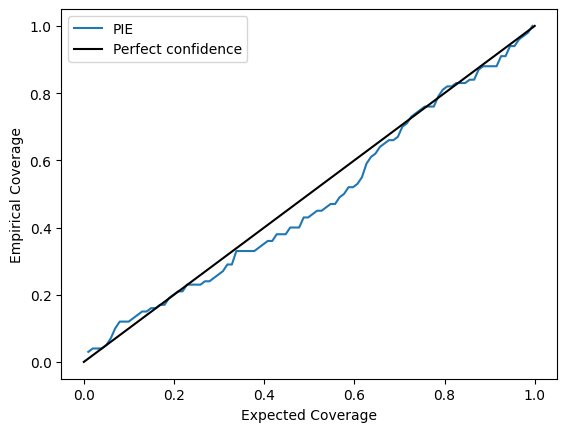

In [14]:
H,X1 = np.histogram(covs_iid, bins = 100, normed = True)
dx = X1[1] - X1[0]
F1 = np.cumsum(H)*dx
plt.plot(X1[1:], F1, label = 'PIE')

plt.plot(np.linspace(0,1,100),np.linspace(0,1,100), color='k', label='Perfect confidence')

plt.xlabel('Expected Coverage')
plt.ylabel('Empirical Coverage')
plt.legend()

/tmp/ipykernel_2194940/3533755502.py:1: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  H,X1 = np.histogram(covs_iid, bins = 100, normed = True)
/tmp/ipykernel_2194940/3533755502.py:6: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  H,X1 = np.histogram(covs_cp, bins = 100, normed = True)


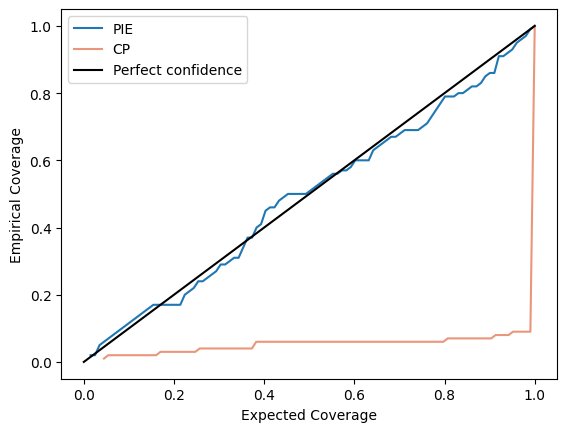

In [25]:
H,X1 = np.histogram(covs_iid, bins = 100, normed = True)
dx = X1[1] - X1[0]
F1 = np.cumsum(H)*dx
plt.plot(X1[1:], F1, label = 'PIE')

H,X1 = np.histogram(covs_cp, bins = 100, normed = True)
dx = X1[1] - X1[0]
F1 = np.cumsum(H)*dx
plt.plot(X1[1:], F1, label = 'CP', color='darksalmon')

plt.plot(np.linspace(0,1,100),np.linspace(0,1,100), color='k', label='Perfect confidence')


plt.xlabel('Expected Coverage')
plt.ylabel('Empirical Coverage')
plt.legend()